In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the ground-truth and evaluate the methods

In [3]:
from intestine_info import load_processed_enterocyte_data, load_original_entero_zonation
from intestine_info import get_intestine_rna_lm_genes
from io_utils import load_all_pipeline_results
from plot_utils import plot_corr_mtx
from scrna_utils import get_gene_df
from general_utils import rank_and_bin

res_dir = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719"
zone_vals = load_original_entero_zonation(just_vals=True)
obs_df, var_df, mtx = load_processed_enterocyte_data(res_dir)
RDIR = os.path.join(res_dir, "entero_data", "results")
pipe_res, all_lams = load_all_pipeline_results(RDIR)
print('Matrix dimension: {}'.format(mtx.shape))
display(pipe_res.keys())
display(all_lams.keys())

[feat_viz INFO] {'Crypt': 0, 'V1': 1, 'V2': 2, 'V3': 3, 'V4': 4, 'V5': 5, 'V6': 6}
[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/result_pc_oracle.plk does not exist
[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/result_graph_oracle.plk does not exist
[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/result_hybrid_oracle.plk does not exist


Matrix dimension: (1383, 9656)


dict_keys(['pc_vanilla', 'graph_vanilla', 'hybrid_vanilla'])

dict_keys(['unsup_graph', 'unsup_pc'])

In [4]:
obs_df.head()

n_genes  n_counts           cell_id
0     2033    6751.0  AAACCTGGTAAGTTCC
1     1135    3754.0  AAACGGGCACCAACCG
2     2559    9224.0  AAACGGGTCACTGGGC
3     1706    5144.0  AAAGATGGTGGACGAT
4     3079   11475.0  AAAGATGGTTCGGGCT

### Compare all lambdas if needed

In [5]:
lm_genes = get_intestine_rna_lm_genes()
lm_genes = lm_genes["high"] + lm_genes["low"]
logger.info("Number of original lm genes: {}".format(len(lm_genes)))
lm_genes = list(set(lm_genes).intersection(set(var_df["gene_ids"])))
lm_genes = sorted(lm_genes)
logger.info("Number of intersecting lm genes: {}".format(len(lm_genes)))

[feat_viz INFO] Loaded 453 genes
[feat_viz INFO] Kept 243 genes with max expr > 0.001 
[feat_viz INFO] Kept 45 high zone genes with geom avg > 3.5 
[feat_viz INFO] Kept 64 low zone genes with geom avg < 2.5 
[feat_viz INFO] Number of original lm genes: 109
[feat_viz INFO] Number of intersecting lm genes: 97


palantir
paga


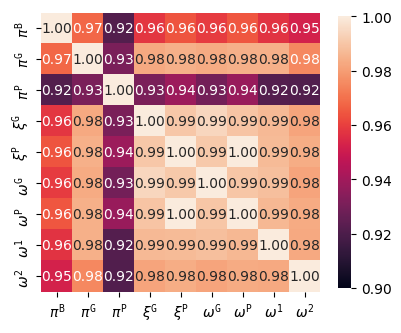

In [22]:
all_lams["smFISH"] = zone_vals
mopts = ["graph", "pc", "hybrid"]
mtypes = ["vanilla"]
for method in mopts:
    for mtype in mtypes:
        key = "{}_{}".format(method, mtype)
        result = pipe_res[key] 
        for lam_t in ["lam_init", "lam_update"]:
            name = "{}_{}".format(key, lam_t)
            all_lams[name] = result[lam_t]
# add lambdas from ti methods
mdir = '/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/ti_methods'
names = ['palantir', 'paga']
for name in names:
    fn = os.path.join(mdir, '{}_obs_df.csv'.format(name))
    df = pd.read_csv(fn)
    df = df.set_index('cell_id')
    df = df.loc[obs_df['cell_id']]
    print(name)
    all_lams[name] = df['pseudotime']

lam_df = pd.DataFrame(all_lams)
# manually switch signs
switch_signs = ["graph_vanilla_lam_init", 
                "graph_vanilla_lam_update",
                "pc_vanilla_lam_update",
                "unsup_graph",
                "unsup_pc"]
for var in switch_signs:
    lam_df[var] = - lam_df[var]
# select and rename here

methods = ["smFISH", 
           "graph_vanilla_lam_init", 
           "pc_vanilla_lam_init", 
           "graph_vanilla_lam_update", 
           "pc_vanilla_lam_update",
           "unsup_graph",
           "unsup_pc",
           "palantir", 
           "paga"]
select_vars = {
    "smFISH": r"$\pi^\mathtt{B}$",
    "graph_vanilla_lam_init": r"$\pi^\mathtt{G}$",
    "pc_vanilla_lam_init": r"$\pi^\mathtt{P}$",
    "graph_vanilla_lam_update": r"$\xi^\mathtt{G}$",
    "pc_vanilla_lam_update": r"$\xi^\mathtt{P}$",
    "unsup_graph": r"$\omega^\mathtt{G}$",
    "unsup_pc": r"$\omega^\mathtt{P}$",
    "palantir": r"$\omega^\mathtt{1}$",
    "paga" : r"$\omega^\mathtt{2}$",
}
sub_df = lam_df[list(select_vars.keys())]
sub_df = sub_df.rename(index=str, columns=select_vars)
sub_df.head()
plot_corr_mtx(sub_df, vmin=0.9)
# save the lambdas to file
# sub_df.to_csv("~/lambdas.csv", index=False)

In [33]:
# load the sets from table
dat_dir = "/share/PI/sabatti/sc_data/intestine2k"
fn = os.path.join(dat_dir, "table_D_zonation_reconstruction.tsv")
tab_d_df = pd.read_table(fn, delimiter="\t").dropna()
tab_d_df = tab_d_df.set_index('Gene name')
tab_d_df = tab_d_df.reindex(var_df.gene_ids)

In [44]:
n_genes = var_df.shape[0]
assert tab_d_df.shape[0] == n_genes, 'number of gene mismatch'
print('Number of genes: {}'.format(n_genes))

Number of genes: 9656


In [45]:
threshold = 0.05
sub_d_df = tab_d_df.loc[tab_d_df['qval'] < 0.05]
n_sel_genes = sub_d_df.shape[0]
print('original : {} ({:.4f}%)'.format(n_sel_genes, n_sel_genes/n_genes*100))

original : 7946 (82.2908%)


In [46]:
# look at the intersection between the three methods
gset = {}
gset['original'] = set(sub_d_df.index)

In [51]:
var_df.head()

gene_ids  n_cells      mean       std   npc
0   Mrpl15      530  0.386412  0.530710   530
1   Lypla1     1045  0.999767  0.698513  1045
2    Tcea1      367  0.225788  0.401705   367
3  Atp6v1h      171  0.101006  0.292252   171
4   Rb1cc1      340  0.220587  0.425791   340

In [52]:
from main_methods import setup_cmp_df
pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(pipe_res)
for i, met in enumerate(mets[:2]):
    gset[met] = set(var_df['gene_ids'][cmp_sets[i]])

[feat_viz INFO] pc_vanilla threshold: 0.0401
[feat_viz INFO] graph_vanilla threshold: 0.0355
[feat_viz INFO] hybrid_vanilla threshold: 0.0273


original : 7946 (82.2908)%
pc_vanilla : 7747 (80.2299)%
graph_vanilla : 6892 (71.3753)%


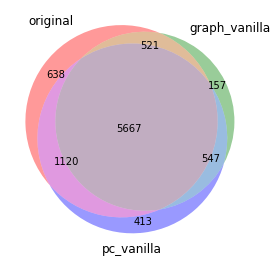

In [81]:
from matplotlib_venn import venn3
for met in gset:
    n_sel_genes = len(gset[met])
    print('{} : {} ({:.4f})%'.format(met, n_sel_genes, n_sel_genes/n_genes*100))
keys = ['original', 'graph_vanilla', 'pc_vanilla']
vals = [gset[k] for k in keys]
fig, ax = plt.subplots(1, 1, figsize=(4.5,4.5))
vd = venn3(vals, keys, ax=ax)
vd.get_label_by_id("110").set_y(0.45)
vd.get_label_by_id("001").set_y(-0.52)
plt.show()

In [80]:
keys

['original', 'pc_vanilla', 'graph_vanilla']

In [59]:
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        m1 = keys[i]
        m2 = keys[j]
        cap = vals[i].intersection(vals[j])
        cup = vals[i].union(vals[j])
        score = len(cap) / len(cup)
        print('{} vs {}: {}'.format(m1, m2, score))

original vs pc_vanilla: 0.7620705142600495
original vs graph_vanilla: 0.7153757225433526
pc_vanilla vs graph_vanilla: 0.737566765578635


[feat_viz INFO] pc_vanilla threshold: 0.0401
[feat_viz INFO] graph_vanilla threshold: 0.0355


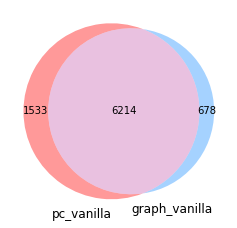

In [5]:
from plot_utils import plot_and_compare_results
def compare_methods(res, mlist):
    cmp_methods = {}
    for m in mlist:
        assert m in res, "{} not found".format(m)
        cmp_methods[m] = res[m]
    plot_and_compare_results(cmp_methods)
compare_methods(pipe_res, ["pc_vanilla", "graph_vanilla"])

[feat_viz INFO] pc_vanilla threshold: 0.0401
[feat_viz INFO] graph_vanilla threshold: 0.0355
[feat_viz INFO] hybrid_vanilla threshold: 0.0273


In [16]:
var_df.head()

gene_ids  n_cells      mean       std   npc
0   Mrpl15      530  0.386412  0.530710   530
1   Lypla1     1045  0.999767  0.698513  1045
2    Tcea1      367  0.225788  0.401705   367
3  Atp6v1h      171  0.101006  0.292252   171
4   Rb1cc1      340  0.220587  0.425791   340

In [10]:
pval_df.shape

(9656, 3)

pc_vanilla : 80.2299%
graph_vanilla : 71.3753%
hybrid_vanilla : 54.7742%


In [7]:
pipe_res

{'pc_vanilla': {'lam_init': array([-0.44025642,  5.4823265 , -7.28304   , ...,  3.9972103 ,
          3.1224914 , -6.32924   ], dtype=float32),
  'lam_update': array([ -9.970622, -20.481222,  19.689318, ..., -21.882849, -20.019737,
          20.451033], dtype=float32),
  'p_vals': array([9.99900010e-05, 9.99900010e-05, 9.99900010e-05, ...,
         7.77622238e-01, 5.93540646e-01, 3.99960004e-04]),
  'rejections': array([   0,    1,    2, ..., 9650, 9651, 9655])},
 'graph_vanilla': {'lam_init': array([-0.01300048, -0.02191447,  0.02364276, ..., -0.02104047,
         -0.01932365,  0.03370192]),
  'lam_update': array([-0.01136195, -0.01989204,  0.01827042, ..., -0.02045793,
         -0.02009152,  0.02030101]),
  'p_vals': array([9.99900010e-05, 9.99900010e-05, 9.99900010e-05, ...,
         7.27527247e-01, 4.39956004e-03, 3.57964204e-02]),
  'rejections': array([   0,    1,    2, ..., 9649, 9650, 9654])},
 'hybrid_vanilla': {'lam_init': array([-0.44025642,  5.4823265 , -7.28304   , ...,  3

### Search for p-values of known genes

In [6]:
from main_methods import setup_cmp_df, get_unique_rejection_df
from plot_utils import create_color_map, plot_full_pattern
from matplotlib.ticker import FormatStrFormatter
from plot_utils import update_boxplot_cols
from plot_utils import plot_gene_expr_comp
from scrna_utils import get_gene_df

cmp_methods = {key: pipe_res[key] for key in ["pc_vanilla", "graph_vanilla"]}
pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(cmp_methods)
pval_df = pd.concat([var_df.reset_index(drop=True), pval_df], axis=1)
report_genes = ["Hamp", "Hamp2", "Igfbp2", "Mup3", "Cyp8b1"]
unique_dict, unique_df = get_unique_rejection_df(cmp_methods, var_df)
unique_glist = {}
top_k = 10
for key in cmp_methods:
    unique_glist[key] = list(unique_dict[key].index[:top_k])
#     display(unique_dict[key].head(top_k))
display(unique_df.head())

[feat_viz INFO] pc_vanilla threshold: 0.0401
[feat_viz INFO] graph_vanilla threshold: 0.0355
[feat_viz INFO] pc_vanilla threshold: 0.0401
[feat_viz INFO] graph_vanilla threshold: 0.0355
[feat_viz INFO] Set selection: (1533, 8)
[feat_viz INFO] Set selection: (678, 8)


n_cells      mean       std  npc  pc_vanilla  graph_vanilla  \
gene_ids                                                                
Gm4262         13  0.011172  0.118423   13      0.0001       0.996200   
Dhdds         123  0.066306  0.225791  123      0.0001       0.953905   
Cbr4           69  0.035134  0.160391   69      0.0001       0.941406   
Coq3           66  0.032493  0.150676   66      0.0001       0.938006   
Prorsd1       163  0.092856  0.270002  163      0.0001       0.936406   

         exclusive_rejection  
gene_ids                      
Gm4262            pc_vanilla  
Dhdds             pc_vanilla  
Cbr4              pc_vanilla  
Coq3              pc_vanilla  
Prorsd1           pc_vanilla

In [30]:
def report_gene_info(report_genes):
    for gene in report_genes:
        if gene in unique_df.index:
            gene_info = unique_df.loc[gene]
            logger.info("{} only rejected by {}".format(gene, gene_info["exclusive_rejection"]))
    display(pval_df[pval_df["gene_ids"].isin(report_genes)].head(5))

def plot_gene_expression(genes, horizontal=False):
    gene_df = get_gene_df(genes, var_df, mtx)
#     report_gene_info(genes)
    plot_gene_expr_comp(lam_df, gene_df, methods, select_vars, horizontal=horizontal)
    
fn = "/share/PI/sabatti/sc_data/intestine2k/extracted/smFISH_genes.csv"
smFISH_genes = list(pd.read_csv(fn, header=None)[0])
logger.info("Number of original smFISH genes: {}".format(len(smFISH_genes)))
smFISH_genes = list(set(smFISH_genes).intersection(set(var_df["gene_ids"])))
smFISH_genes = sorted(smFISH_genes)
logger.info("Number of intersecting smFISH genes: {}".format(len(smFISH_genes)))
report_gene_info(smFISH_genes)   

graph_top_uniq_genes = unique_glist["graph_vanilla"][:8]
report_gene_info(graph_top_uniq_genes)   

[feat_viz INFO] Number of original smFISH genes: 23
[feat_viz INFO] Number of intersecting smFISH genes: 22
[feat_viz INFO] Cdh1 only rejected by graph_vanilla


gene_ids  n_cells      mean       std   npc  pc_vanilla  graph_vanilla
149      Cps1      624  0.674070  0.844695   624      0.0001         0.0001
310      Pigr     1284  2.565508  0.998651  1284      0.0001         0.0001
987   Slc28a2      258  0.406770  0.986160   258      0.0001         0.0001
1196      Ada      716  1.053582  1.464546   716      0.0001         0.0001
1583   Slc2a2      650  0.663044  0.774591   650      0.0001         0.0001

[feat_viz INFO] Cyp4f14 only rejected by graph_vanilla
[feat_viz INFO] Aoc1 only rejected by graph_vanilla
[feat_viz INFO] Acbd4 only rejected by graph_vanilla
[feat_viz INFO] Eif4ebp1 only rejected by graph_vanilla
[feat_viz INFO] Agmo only rejected by graph_vanilla
[feat_viz INFO] Otop3 only rejected by graph_vanilla
[feat_viz INFO] Tcn2 only rejected by graph_vanilla
[feat_viz INFO] Sec23a only rejected by graph_vanilla


gene_ids  n_cells      mean       std  npc  pc_vanilla  graph_vanilla
3424      Aoc1      990  1.016379  0.773854  990    0.990301         0.0001
5056  Eif4ebp1      203  0.121197  0.315728  203    0.977202         0.0001
6366      Tcn2      937  0.894356  0.739364  937    0.947905         0.0001
6987     Acbd4      858  0.729065  0.659869  858    0.982502         0.0001
7043     Otop3      138  0.100307  0.318529  138    0.960904         0.0001

[feat_viz INFO] x_star_df dim: (1383, 22)


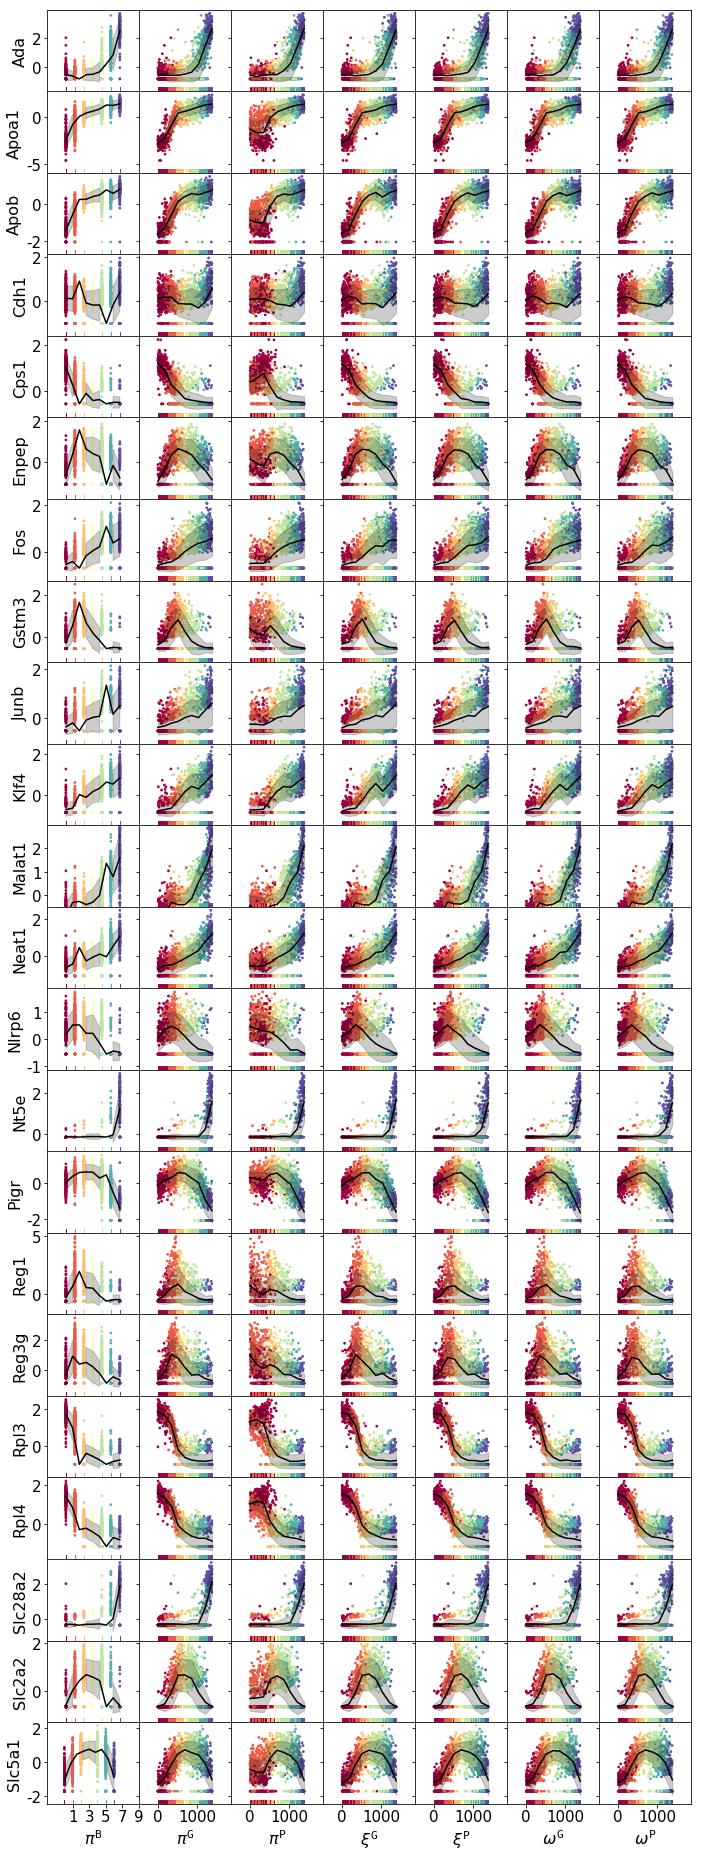

In [33]:
plot_gene_expression(smFISH_genes)

[feat_viz INFO] x_star_df dim: (1383, 8)


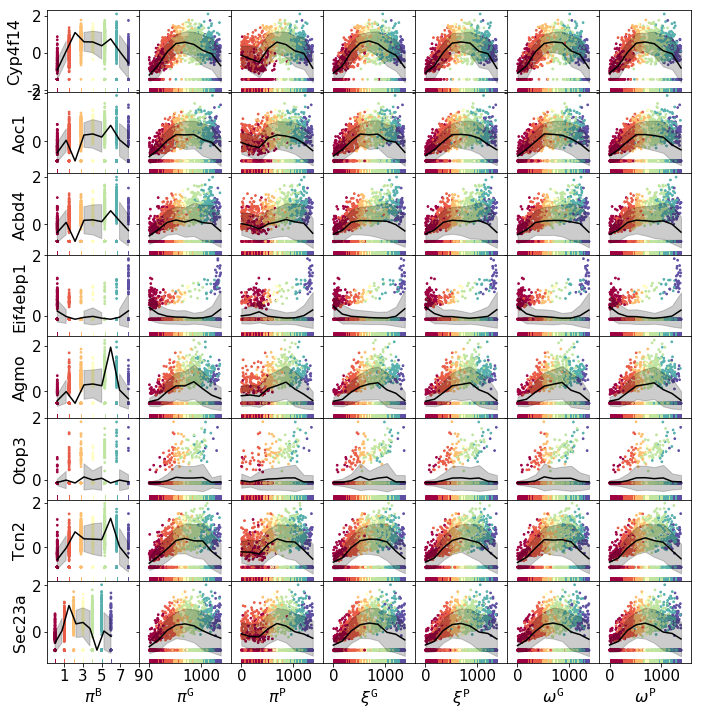

In [34]:
plot_gene_expression(graph_top_uniq_genes)

[feat_viz INFO] pc_vanilla threshold: 0.0401
[feat_viz INFO] graph_vanilla threshold: 0.0355
[feat_viz INFO] Set selection: (1533, 10)
[feat_viz INFO] Set selection: (678, 10)
[matplotlib.legend WARNING] No handles with labels found to put in legend.
[matplotlib.legend WARNING] No handles with labels found to put in legend.


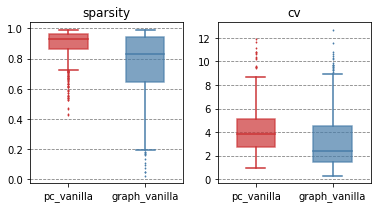

In [32]:
def plot_contrast_rejections(res_dict, var_df, plain=False, fn=None):
    var_df = var_df.copy()
    var_df["cv"] = var_df["std"] / var_df["mean"]
    var_df["sparsity"] = 1 - (var_df["n_cells"]/ mtx.shape[0])

    fontsize=15
    my_pal = {"pc_vanilla": "red", "graph_vanilla":"blue"}
    _, df_comp = get_unique_rejection_df(res_dict, var_df)
    plt_vars = ['sparsity', 'cv']
    fig, axes = plt.subplots(1, len(plt_vars), figsize=(len(plt_vars)*2.7, 3))
    for i_plt, var in enumerate(plt_vars):
        ax = axes[i_plt]
        

        sns.boxplot(x="exclusive_rejection", y=var, 
                    data=df_comp, ax=ax, 
                    palette="Set1",
                    width=0.5, fliersize=1)
        ax.set_title(var)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed')
        update_boxplot_cols(ax)
        if plain:
            ax.set_title(None)
            ax.set_xticks([])
            ax.tick_params(axis='both', which='major', pad=2, labelsize=fontsize)
    plt.tight_layout()
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        logger.info("Saved figure to: {}".format(fn))
    plt.show()
    
plot_contrast_rejections(cmp_methods, var_df)

[feat_viz INFO] Brap only rejected by pc_vanilla


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
1525     Brap     1189  1.103937  0.646323  1189  0.585471  0.159717   

      pc_vanilla  graph_vanilla  
1525      0.0001       0.018298

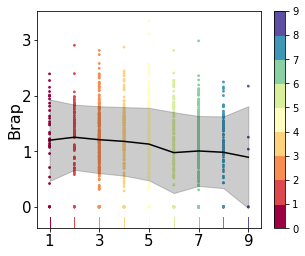

In [37]:
plot_gene_expr_comp(lam_df, x_d, ["Brap"], ["smFISH"], horizontal=True)

## Save figures to file

In [38]:
# TODO: CHANGE FDIR FOR ENTERO - THIS WAS FOR HEPA
# FDIR = "/share/PI/sabatti/feat_viz/main_figs"

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_heatmap.pdf


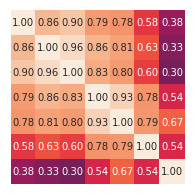

In [39]:
fn = os.path.join(FDIR, "real_data_heatmap.pdf")
plot_corr_mtx(sub_df, plain=True, fn=fn)

[feat_viz INFO] pc_vanilla threshold: 0.0089
[feat_viz INFO] graph_vanilla threshold: 0.0083
[feat_viz INFO] Set selection: (793, 10)
[feat_viz INFO] Set selection: (661, 10)
[matplotlib.legend WARNING] No handles with labels found to put in legend.
[matplotlib.legend WARNING] No handles with labels found to put in legend.
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_box_uniq.pdf


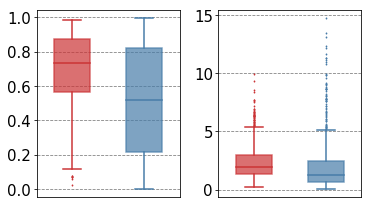

In [47]:
fn = os.path.join(FDIR, "real_data_box_uniq.pdf")
plot_contrast_rejections(cmp_methods, var_df, plain=True, fn=fn)

[feat_viz INFO] Brap only rejected by pc_vanilla


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
1525     Brap     1189  1.103937  0.646323  1189  0.585471  0.159717   

      pc_vanilla  graph_vanilla  
1525      0.0001       0.018298

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_scalebar.pdf


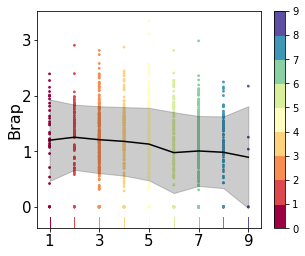

gene_ids  n_cells      mean       std   npc        cv  sparsity  \
904       Alb     1415  6.190163  0.610225  1415  0.098580  0.000000   
1191      Asl     1397  2.707551  0.570133  1397  0.210571  0.012721   
1200     Ass1     1411  3.164296  0.588850  1411  0.186092  0.002827   
2350   Cyp2e1     1221  3.086100  2.132811  1221  0.691102  0.137102   
2351   Cyp2f2     1235  2.269190  1.415569  1235  0.623821  0.127208   
3496     Glul      523  0.347392  0.661617   523  1.904525  0.630389   

      pc_vanilla  graph_vanilla  
904       0.0001         0.0001  
1191      0.0001         0.0001  
1200      0.0001         0.0001  
2350      0.0001         0.0001  
2351      0.0001         0.0001  
3496      0.0001         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_lm.pdf


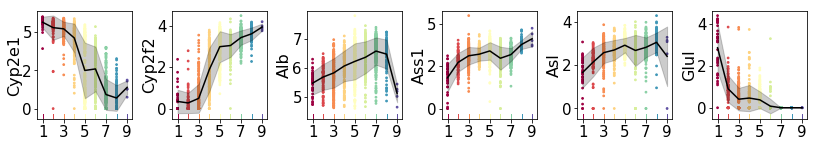

[feat_viz INFO] Igfbp2 only rejected by graph_vanilla


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
3765    Hamp2     1158  1.595090  1.069451  1158  0.670465  0.181625   
4044   Igfbp2     1257  1.622701  0.830093  1257  0.511550  0.111661   

      pc_vanilla  graph_vanilla  
3765    0.000100         0.0001  
4044    0.033297         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_val.pdf


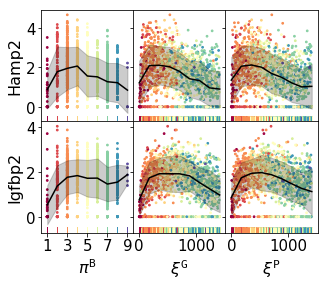

[feat_viz INFO] C4bp only rejected by graph_vanilla
[feat_viz INFO] Phf3 only rejected by pc_vanilla


gene_ids  n_cells      mean       std  npc        cv  sparsity  \
1604     C4bp      858  0.712044  0.701095  858  0.984623  0.393640   
5761     Phf3      582  0.331940  0.470883  582  1.418580  0.588693   

      pc_vanilla  graph_vanilla  
1604    0.861914       0.000100  
5761    0.000100       0.838516

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_uniq.pdf


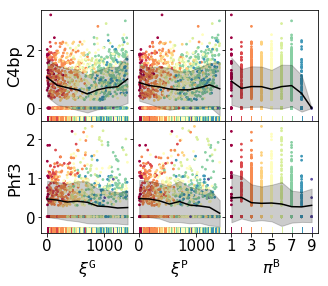

In [49]:
fn = os.path.join(FDIR, "real_data_scalebar.pdf")
plot_gene_expr_comp(lam_df, x_d, ["Brap"], ["smFISH"], horizontal=True, fn=fn)
fn = os.path.join(FDIR, "real_data_genes_lm.pdf")
plot_gene_expr_comp(lam_df, x_d, lm_genes, ["smFISH"], horizontal=True, fn=fn)
fn = os.path.join(FDIR, "real_data_genes_val.pdf")
plot_gene_expr_comp(lam_df, x_d, ["Hamp2", "Igfbp2"], ["smFISH", "graph_vanilla_lam_update", "pc_vanilla_lam_update"], fn=fn)
fn = os.path.join(FDIR, "real_data_genes_uniq.pdf")
plot_gene_expr_comp(lam_df, x_d, ["C4bp", "Phf3"], ["graph_vanilla_lam_update", "pc_vanilla_lam_update","smFISH"],fn=fn)

gene_ids  n_cells      mean       std   npc        cv  sparsity  \
904       Alb     1415  6.190163  0.610225  1415  0.098580  0.000000   
1191      Asl     1397  2.707551  0.570133  1397  0.210571  0.012721   
1200     Ass1     1411  3.164296  0.588850  1411  0.186092  0.002827   
2350   Cyp2e1     1221  3.086100  2.132811  1221  0.691102  0.137102   
2351   Cyp2f2     1235  2.269190  1.415569  1235  0.623821  0.127208   
3496     Glul      523  0.347392  0.661617   523  1.904525  0.630389   

      pc_vanilla  graph_vanilla  
904       0.0001         0.0001  
1191      0.0001         0.0001  
1200      0.0001         0.0001  
2350      0.0001         0.0001  
2351      0.0001         0.0001  
3496      0.0001         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_all_lm.png


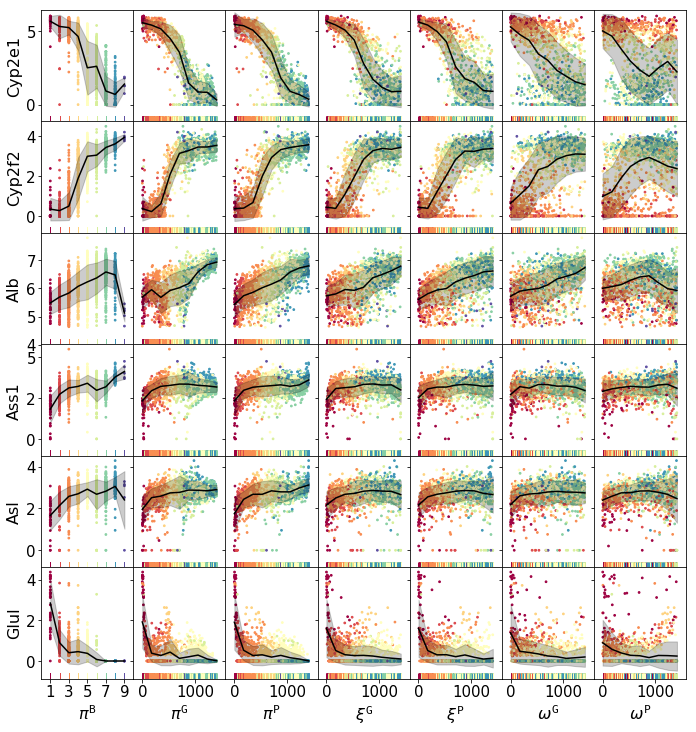

In [43]:
plt_id = "lm"
fn = os.path.join(FDIR, "real_data_genes_all_{}.png".format(plt_id))
plot_gene_expr_comp(lam_df, x_d, lm_genes, methods, fn=fn)

[feat_viz INFO] Igfbp2 only rejected by graph_vanilla


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
2371   Cyp8b1     1315  1.913578  0.753823  1315  0.393934  0.070671   
3764     Hamp     1327  2.937353  1.240587  1327  0.422349  0.062191   
3765    Hamp2     1158  1.595090  1.069451  1158  0.670465  0.181625   
4044   Igfbp2     1257  1.622701  0.830093  1257  0.511550  0.111661   
5043     Mup3     1366  2.975959  1.237950  1366  0.415984  0.034629   

      pc_vanilla  graph_vanilla  
2371    0.000100         0.0001  
3764    0.000500         0.0001  
3765    0.000100         0.0001  
4044    0.033297         0.0001  
5043    0.000100         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_all_report.png


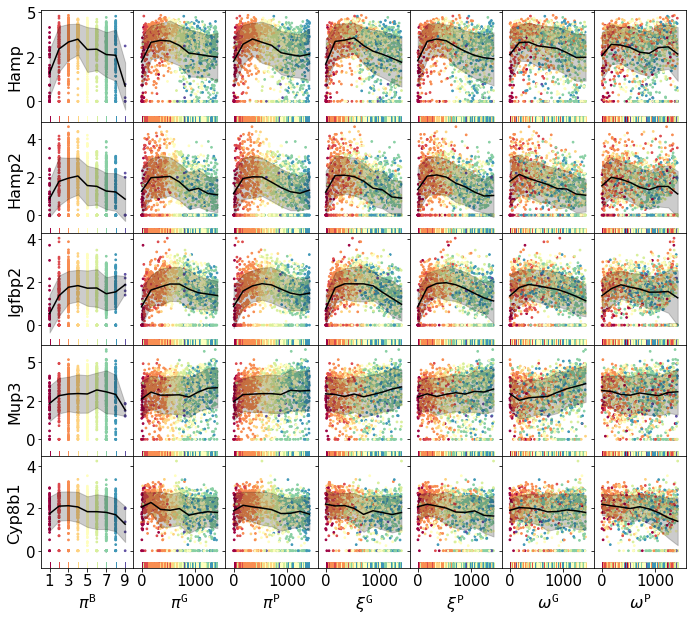

In [44]:
plt_id = "report"
fn = os.path.join(FDIR, "real_data_genes_all_{}.png".format(plt_id))
plot_gene_expr_comp(lam_df, x_d, report_genes, methods, fn=fn)

[feat_viz INFO] Fgl1 only rejected by graph_vanilla
[feat_viz INFO] Ttpa only rejected by graph_vanilla
[feat_viz INFO] Mat1a only rejected by graph_vanilla
[feat_viz INFO] Ces1e only rejected by graph_vanilla
[feat_viz INFO] Ptplad1 only rejected by graph_vanilla
[feat_viz INFO] Hist1h1b only rejected by graph_vanilla
[feat_viz INFO] Aplp2 only rejected by graph_vanilla
[feat_viz INFO] C4bp only rejected by graph_vanilla


['Fgl1', 'Ttpa', 'Mat1a', 'Ces1e', 'Ptplad1', 'Hist1h1b', 'Aplp2', 'C4bp']


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
1045     Aplp2     1154  1.118560  0.676803  1154  0.605067  0.184452   
1604      C4bp      858  0.712044  0.701095   858  0.984623  0.393640   
1915     Ces1e     1005  0.789574  0.623091  1005  0.789148  0.289753   
3252      Fgl1     1180  1.262376  0.716935  1180  0.567925  0.166078   
3855  Hist1h1b       29  0.021064  0.164727    29  7.820231  0.979505   
4653     Mat1a     1414  3.928493  0.370627  1414  0.094343  0.000707   
6238   Ptplad1      656  0.384490  0.491875   656  1.279292  0.536396   
8138      Ttpa      607  0.350444  0.494714   607  1.411676  0.571025   

      pc_vanilla  graph_vanilla  
1045    0.866513         0.0001  
1604    0.861914         0.0001  
1915    0.902010         0.0001  
3252    0.985501         0.0001  
3855    0.867813         0.0001  
4653    0.914909         0.0001  
6238    0.868713         0.0001  
8138    0.917508         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_all_graph.png


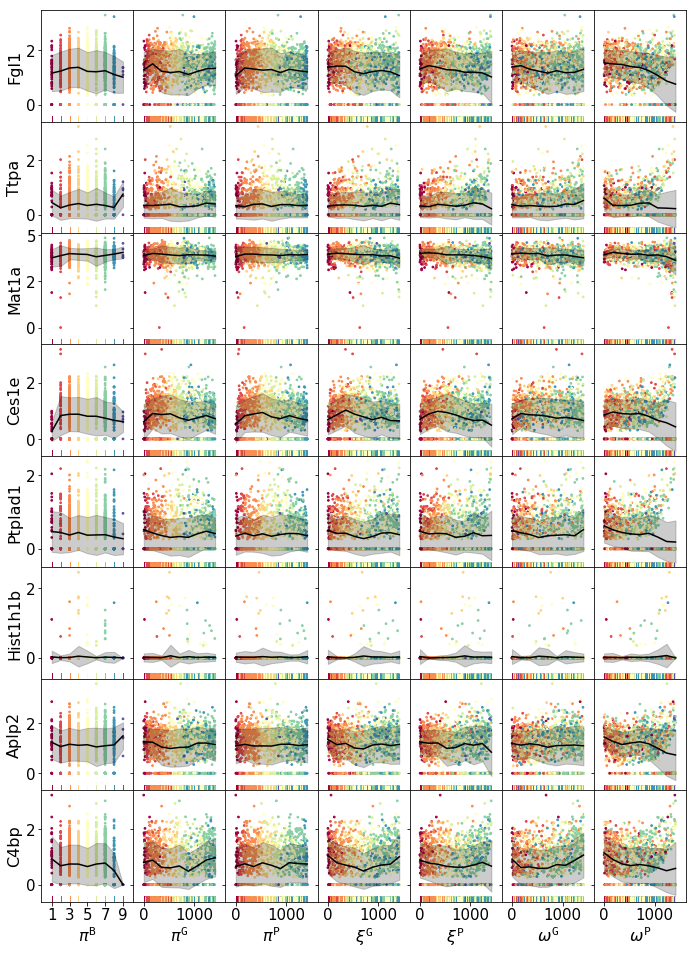

In [45]:
plt_id = "graph"
genes = unique_glist["graph_vanilla"][:8]
print(genes)
fn = os.path.join(FDIR, "real_data_genes_all_{}.png".format(plt_id))
plot_gene_expr_comp(lam_df, x_d, genes, methods, fn=fn)

[feat_viz INFO] Phf3 only rejected by pc_vanilla
[feat_viz INFO] Pias4;PIAS-gamma only rejected by pc_vanilla
[feat_viz INFO] Serpine2 only rejected by pc_vanilla
[feat_viz INFO] Mylk;Mlyk only rejected by pc_vanilla
[feat_viz INFO] Acyp1 only rejected by pc_vanilla
[feat_viz INFO] Dnaja4 only rejected by pc_vanilla
[feat_viz INFO] Snhg6 only rejected by pc_vanilla
[feat_viz INFO] Aldh1a7 only rejected by pc_vanilla


['Phf3', 'Pias4;PIAS-gamma', 'Serpine2', 'Mylk;Mlyk', 'Acyp1', 'Dnaja4', 'Snhg6', 'Aldh1a7']


gene_ids  n_cells      mean       std  npc        cv  sparsity  \
781              Acyp1      371  0.187429  0.366070  371  1.953116  0.737809   
908            Aldh1a7      716  0.439747  0.516800  716  1.175222  0.493993   
2627            Dnaja4       55  0.021674  0.119090   55  5.494523  0.961131   
5072         Mylk;Mlyk      426  0.226912  0.418408  426  1.843921  0.698940   
5761              Phf3      582  0.331940  0.470883  582  1.418580  0.588693   
5785  Pias4;PIAS-gamma      174  0.090250  0.276415  174  3.062762  0.877032   
6967          Serpine2      189  0.096100  0.278162  189  2.894513  0.866431   
7296             Snhg6      616  0.353233  0.471623  616  1.335159  0.564664   

      pc_vanilla  graph_vanilla  
781       0.0001       0.412859  
908       0.0001       0.337766  
2627      0.0001       0.401760  
5072      0.0001       0.598340  
5761      0.0001       0.838516  
5785      0.0001       0.692231  
6967      0.0001       0.623338  
7296      0.0001       0.338466

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_all_pca.png


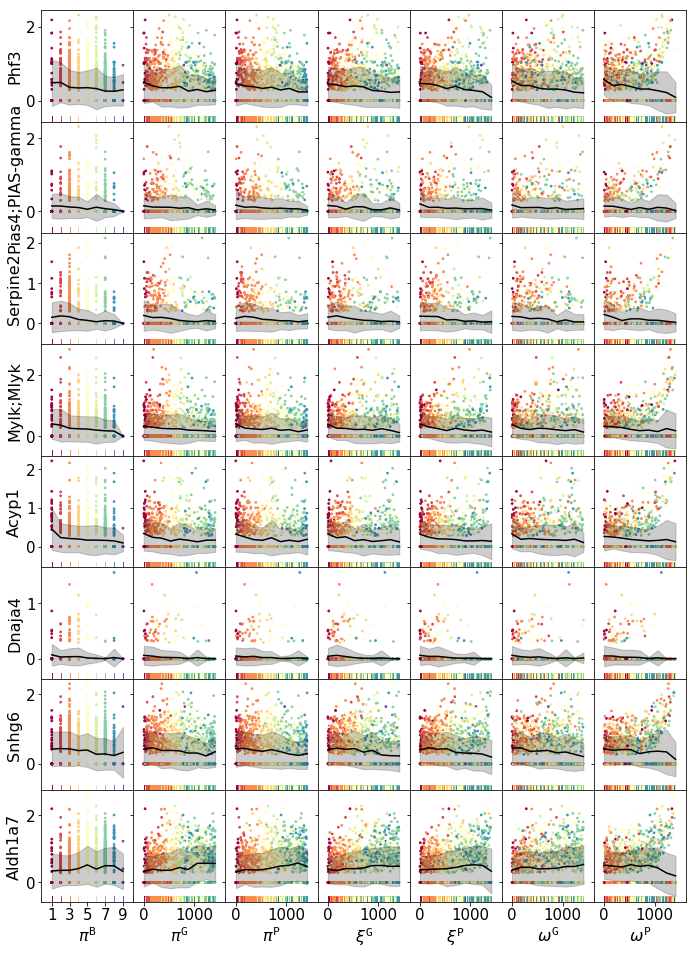

In [46]:
plt_id = "pca"
genes = unique_glist["pc_vanilla"][:8]
print(genes)
fn = os.path.join(FDIR, "real_data_genes_all_{}.png".format(plt_id))
plot_gene_expr_comp(lam_df, x_d, genes, methods, fn=fn)